In [2]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import glob
import nibabel as nib
import cv2
import imageio
from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image
from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

In [3]:
# Create a meta file for nii files processing

file_list = []
for dirname, _, filenames in os.walk('/kaggle/input/liver-tumor-segmentation'):
    for filename in filenames:
#         print(os.path.join(dirname, filename))
        file_list.append((dirname,filename)) 

for dirname, _, filenames in os.walk('/kaggle/input/liver-tumor-segmentation-part-2'):
    for filename in filenames:
        file_list.append((dirname,filename)) 

df_files = pd.DataFrame(file_list, columns =['dirname', 'filename']) 
df_files.sort_values(by=['filename'], ascending=True)    

,dirname,filename
89,/kaggle/input/liver-tumor-segmentation/segmentations,segmentation-0.nii
81,/kaggle/input/liver-tumor-segmentation/segmentations,segmentation-1.nii
142,/kaggle/input/liver-tumor-segmentation/segmentations,segmentation-10.nii
31,/kaggle/input/liver-tumor-segmentation/segmentations,segmentation-100.nii
45,/kaggle/input/liver-tumor-segmentation/segmentations,segmentation-101.nii
...,...,...
243,/kaggle/input/liver-tumor-segmentation-part-2/volume_pt6,volume-95.nii
222,/kaggle/input/liver-tumor-segmentation-part-2/volume_pt6,volume-96.nii
217,/kaggle/input/liver-tumor-segmentation-part-2/volume_pt6,volume-97.nii
252,/kaggle/input/liver-tumor-segmentation-part-2/volume_pt6,volume-98.nii


In [4]:
# Map CT scan and label 

df_files["mask_dirname"] = "" ; df_files["mask_filename"] = ""

for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"
    
    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = "../input/liver-tumor-segmentation/segmentations"

df_files_test= df_files[df_files.mask_filename=='']
# drop segment rows
df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True) 
print(len(df_files))
df_files
#df_files_test

131


,dirname,filename,mask_dirname,mask_filename
0,/kaggle/input/liver-tumor-segmentation/volume_pt1,volume-0.nii,../input/liver-tumor-segmentation/segmentations,segmentation-0.nii
1,/kaggle/input/liver-tumor-segmentation/volume_pt1,volume-1.nii,../input/liver-tumor-segmentation/segmentations,segmentation-1.nii
2,/kaggle/input/liver-tumor-segmentation/volume_pt1,volume-10.nii,../input/liver-tumor-segmentation/segmentations,segmentation-10.nii
3,/kaggle/input/liver-tumor-segmentation-part-2/volume_pt6,volume-100.nii,../input/liver-tumor-segmentation/segmentations,segmentation-100.nii
4,/kaggle/input/liver-tumor-segmentation-part-2/volume_pt8,volume-101.nii,../input/liver-tumor-segmentation/segmentations,segmentation-101.nii
...,...,...,...,...
126,/kaggle/input/liver-tumor-segmentation-part-2/volume_pt6,volume-95.nii,../input/liver-tumor-segmentation/segmentations,segmentation-95.nii
127,/kaggle/input/liver-tumor-segmentation-part-2/volume_pt6,volume-96.nii,../input/liver-tumor-segmentation/segmentations,segmentation-96.nii
128,/kaggle/input/liver-tumor-segmentation-part-2/volume_pt6,volume-97.nii,../input/liver-tumor-segmentation/segmentations,segmentation-97.nii
129,/kaggle/input/liver-tumor-segmentation-part-2/volume_pt6,volume-98.nii,../input/liver-tumor-segmentation/segmentations,segmentation-98.nii


In [5]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [6]:
# Read sample
sample = 0
sample_ct   = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
sample_mask  = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])
print(sample_ct.shape) 
print(sample_mask.shape)
print(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])

(512, 512, 75)
(512, 512, 75)
/kaggle/input/liver-tumor-segmentation/volume_pt1/volume-0.nii


In [7]:
print(np.amin(sample_ct), np.amax(sample_ct))
print(np.amin(sample_mask), np.amax(sample_mask))

-3024.0 1410.0
0.0 2.0


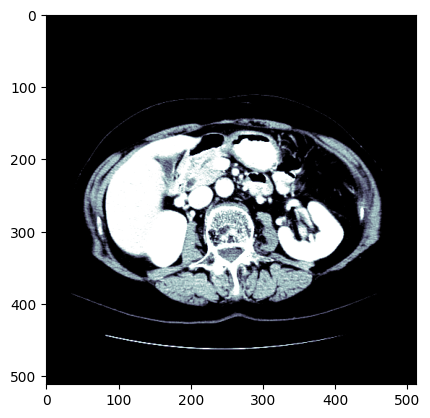

In [8]:
# Preprocess the nii file 
# Source https://docs.fast.ai/medical.imaging

dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    custom = (200,60)
)

@patch
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

plt.imshow(tensor(sample_ct[...,50].astype(np.float32)).windowed(*dicom_windows.liver), cmap=plt.cm.bone);

In [9]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(18,15))

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')
    
    plt.subplot(1,4,2)
    plt.imshow(tensor(array_list[0].astype(np.float32)).windowed(*dicom_windows.liver), cmap='bone');
    plt.title('Windowed Image')
    
    plt.subplot(1,4,3)
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Mask')
    
    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Liver & Mask')


    plt.show()

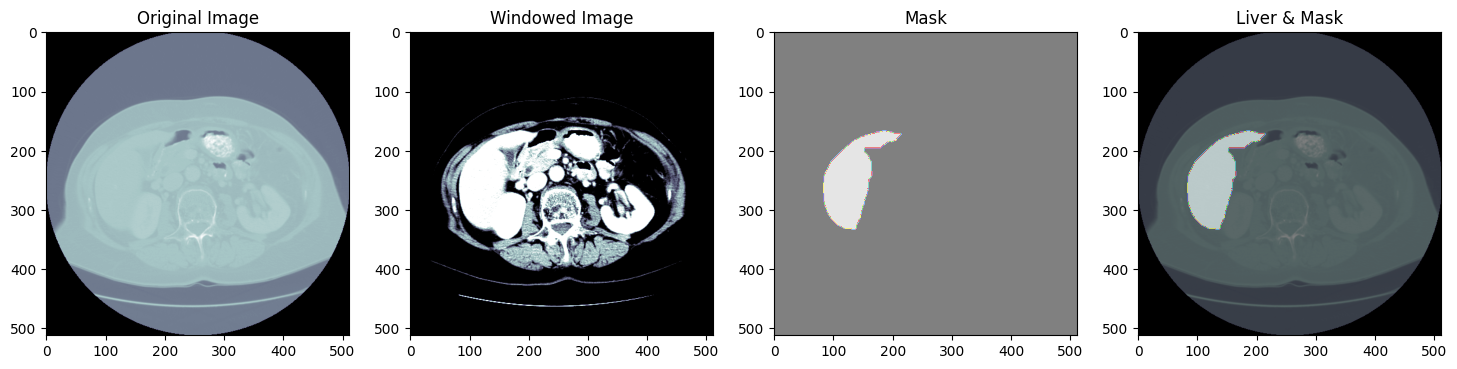

In [10]:
sample=50
sample_slice = tensor(sample_ct[...,sample].astype(np.float32))

plot_sample([sample_ct[...,sample], sample_mask[...,sample]])

In [11]:
# Check the mask values
mask = Image.fromarray(sample_mask[...,sample].astype('uint8'), mode="L")
unique, counts = np.unique(mask, return_counts=True)
print( np.array((unique, counts)).T)

[[     0 252049]
 [     1  10095]]


<Axes: >

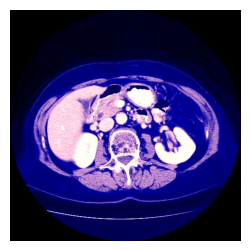

In [12]:
# Preprocessing functions
# Source https://docs.fast.ai/medical.imaging

class TensorCTScan(TensorImageBW): _show_args = {'cmap':'bone'}

@patch
def freqhist_bins(self:Tensor, n_bins=100):
    ''''"A function to split the range of pixel values into groups, 
    such that each group has around the same number of pixels"'''
    imsd = self.view(-1).sort()[0]
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                   tensor([0.999])])
    t = (len(imsd)*t).long()
    return imsd[t].unique()
    
@patch
def hist_scaled(self:Tensor, brks=None):
    "Scales a tensor using `freqhist_bins` to values between 0 and 1"
    if self.device.type=='cuda': return self.hist_scaled_pt(brks)
    if brks is None: brks = self.freqhist_bins()
    ys = np.linspace(0., 1., len(brks))
    x = self.numpy().flatten()
    x = np.interp(x, brks.numpy(), ys)
    return tensor(x).reshape(self.shape).clamp(0.,1.)
    
    
@patch
def to_nchan(x:Tensor, wins, bins=None):
    res = [x.windowed(*win) for win in wins]
    if not isinstance(bins,int) or bins!=0: res.append(x.hist_scaled(bins).clamp(0,1))
    dim = [0,1][x.dim()==3]
    return TensorCTScan(torch.stack(res, dim=dim))

@patch
def save_jpg(x:(Tensor), path, wins, bins=None, quality=90):
    fn = Path(path).with_suffix('.jpg')
    x = (x.to_nchan(wins, bins)*255).byte()
    im = Image.fromarray(x.permute(1,2,0).numpy(), mode=['RGB','CMYK'][x.shape[0]==4])
    im.save(fn, quality=quality)

_,axs=subplots(1,1)

sample_slice.save_jpg('test.jpg', [dicom_windows.liver,dicom_windows.custom])
show_image(Image.open('test.jpg'), ax=axs[0])

In [13]:
df_files_1=df_files[0:30]
df_files_1

,dirname,filename,mask_dirname,mask_filename
0,/kaggle/input/liver-tumor-segmentation/volume_pt1,volume-0.nii,../input/liver-tumor-segmentation/segmentations,segmentation-0.nii
1,/kaggle/input/liver-tumor-segmentation/volume_pt1,volume-1.nii,../input/liver-tumor-segmentation/segmentations,segmentation-1.nii
2,/kaggle/input/liver-tumor-segmentation/volume_pt1,volume-10.nii,../input/liver-tumor-segmentation/segmentations,segmentation-10.nii
3,/kaggle/input/liver-tumor-segmentation-part-2/volume_pt6,volume-100.nii,../input/liver-tumor-segmentation/segmentations,segmentation-100.nii
4,/kaggle/input/liver-tumor-segmentation-part-2/volume_pt8,volume-101.nii,../input/liver-tumor-segmentation/segmentations,segmentation-101.nii
5,/kaggle/input/liver-tumor-segmentation-part-2/volume_pt8,volume-102.nii,../input/liver-tumor-segmentation/segmentations,segmentation-102.nii
6,/kaggle/input/liver-tumor-segmentation-part-2/volume_pt8,volume-103.nii,../input/liver-tumor-segmentation/segmentations,segmentation-103.nii
7,/kaggle/input/liver-tumor-segmentation-part-2/volume_pt8,volume-104.nii,../input/liver-tumor-segmentation/segmentations,segmentation-104.nii
8,/kaggle/input/liver-tumor-segmentation-part-2/volume_pt8,volume-105.nii,../input/liver-tumor-segmentation/segmentations,segmentation-105.nii
9,/kaggle/input/liver-tumor-segmentation-part-2/volume_pt8,volume-106.nii,../input/liver-tumor-segmentation/segmentations,segmentation-106.nii


In [ ]:
import random

GENERATE_JPG_FILES = True   # warning: generation takes ~ 1h

if GENERATE_JPG_FILES:
    path = Path(".")

    os.makedirs('train_images', exist_ok=True)
    os.makedirs('train_masks', exist_ok=True)

    # Randomly select 1/3 of the indices
    random_indices = random.sample(range(len(df_files)), len(df_files) // 2)

    for ii in tqdm(random_indices):  # take 1/3 nii files for training
        curr_ct = read_nii(df_files.loc[ii, 'dirname'] + "/" + df_files.loc[ii, 'filename'])
        curr_mask = read_nii(df_files.loc[ii, 'mask_dirname'] + "/" + df_files.loc[ii, 'mask_filename'])
        curr_file_name = str(df_files.loc[ii, 'filename']).split('.')[0]
        curr_dim = curr_ct.shape[2]  # 512, 512, curr_dim

        for curr_slice in range(0, curr_dim, 2):  # export every 2nd slice for training
            data = tensor(curr_ct[..., curr_slice].astype(np.float32))
            mask = Image.fromarray(curr_mask[..., curr_slice].astype('uint8'), mode="L")
            data.save_jpg(f"train_images/{curr_file_name}_slice_{curr_slice}.jpg", [dicom_windows.liver, dicom_windows.custom])
            mask.save(f"train_masks/{curr_file_name}_slice_{curr_slice}_mask.png")
else:
    path = Path("../input/liver-segmentation-with-fastai-v2")  # read jpg from saved kernel output


  0%|          | 0/65 [00:00<?, ?it/s]

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
from sklearn.model_selection import train_test_split

# Set the directories
images_dir = 'train_images'
masks_dir = 'train_masks'

# Get the list of image file names
all_image_file_names = sorted(os.listdir(images_dir))

# Randomly select 9000 images
selected_image_file_names = random.sample(all_image_file_names, 9000)

# Load selected images and masks with resizing
target_size = (128, 128)
images = [np.array(Image.open(os.path.join(images_dir, fname)).resize(target_size)) for fname in selected_image_file_names]

# Adjust file extension for masks
mask_file_names = [fname.replace('.jpg', '_mask.png') for fname in selected_image_file_names]
masks = [np.array(Image.open(os.path.join(masks_dir, fname)).resize(target_size)) for fname in mask_file_names]

# Convert the lists to numpy arrays
images = np.array(images)
masks = np.array(masks)

# Normalize images to [0, 1]
images = images / 255.0

# Reshape masks to include a channel dimension
masks = masks.reshape((masks.shape[0], masks.shape[1], masks.shape[2], 1))


In [ ]:
# Split the data into training, validation, and test sets
# 70% training, 20% validation, 10% test
x_train, x_temp, y_train, y_temp = train_test_split(images, masks, test_size=0.3, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=1/3, random_state=42)

In [ ]:
import matplotlib.pyplot as plt

# Function to display images and masks
def display_images_and_masks(images, masks, num_samples=2):
    # Randomly select samples
    sample_indices = random.sample(range(images.shape[0]), num_samples)

    for i in range(num_samples):
        index = sample_indices[i]

        # Display the image
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(images[index])
        plt.title("Image {}".format(index))
        plt.axis("off")

        # Display the mask
        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(masks[index].squeeze(), cmap='gray')
        plt.title("Mask {}".format(index))
        plt.axis("off")

    plt.show()

# Display two random images and masks
display_images_and_masks(x_train, y_train)

In [ ]:
y_train.shape, x_train.shape

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def create_fcn_model(input_shape=(128, 128, 3), target_shape=(128, 128, 1)):
    model = keras.Sequential()

    # Encoder
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Decoder with Skip Connections
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())

    # Output layer
    model.add(layers.Conv2D(1, (1, 1), activation='sigmoid'))  # Assuming binary classification

    # Crop to match the target shape
    crop_height = (model.output_shape[1] - target_shape[0]) // 2
    crop_width = (model.output_shape[2] - target_shape[1]) // 2
    model.add(layers.Cropping2D(cropping=((crop_height, crop_height), (crop_width, crop_width))))

    return model
# Create the FCN model
model = create_fcn_model()

# Display the model summary
model.summary()
model.save('fcn_model.h5')

In [20]:
import tensorflow as tf

def dice_coefficient(y_true, y_pred):
    smooth = 1.0  # Smoothing factor to avoid division by zero
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

checkpoint = tf.keras.callbacks.ModelCheckpoint("fcn_model.h5", monitor='val_loss', verbose=1, patience = 3,save_best_only=True,
                                                save_weights_only=True, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1)

In [ ]:
from tensorflow.keras.optimizers import Adam
# Compile the model [0.001,0001, 6e-e]
model.compile(optimizer=Adam(lr=.001),loss='binary_crossentropy',
              metrics=[dice_coefficient])

In [ ]:
# Train the model
history = model.fit(x_train, y_train, epochs=5, batch_size=16,
          validation_data=(x_valid, y_valid), callbacks=[reduce_lr,checkpoint])
model.save('fcn_model.h5')

In [ ]:
import matplotlib.pyplot as plt
def show_history(history, train, validation):
    plt.plot(history.history[train])
    plt.plot(history.history[validation])
    plt.title('Train History')
    plt.ylabel('train')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='center right')
    plt.show()
show_history(history, 'dice_coefficient', 'val_dice_coefficient')

In [ ]:
show_history(history, 'loss', 'val_loss')

In [ ]:
scores = model.evaluate(x_valid, y_valid)
scores[1]

In [ ]:
prediction = model.predict(x_test)
#print(prediction)
#print(y_test)

In [ ]:
test_scores = model.evaluate(x_test, y_test)
test_scores[1]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have x_test and y_test
# Replace this with the actual index of the image you want to visualize
image_index = 44

# Load the image and true mask
input_image = x_test[image_index]
true_mask = y_test[image_index]

# Obtain the predicted mask from model2
predicted_mask = model.predict(np.expand_dims(input_image, axis=0))[0]

# Threshold the predicted mask (assuming it's a binary mask)
threshold = 0.5  # Adjust this threshold based on your model's output
predicted_mask_binary = (predicted_mask > threshold).astype(np.uint8)

# Plotting
plt.figure(figsize=(12, 4))

# Plot original image
plt.subplot(1, 3, 1)
plt.imshow(input_image)
plt.title('Original Image')

# Plot true mask
plt.subplot(1, 3, 2)
plt.imshow(true_mask[:, :, 0], cmap='gray')
plt.title('True Mask')

# Plot predicted mask
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask_binary[:, :, 0], cmap='gray')
plt.title('Predicted Mask')

plt.show()


In [16]:
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation, concatenate
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
def modified_unet_model(input_shape=(128, 128, 3)):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(32, (3, 3), padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(32, (3, 3), padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(64, (3, 3), padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = Conv2D(128, (3, 3), padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(128, (3, 3), padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)

    # Decoder
    up4 = UpSampling2D(size=(2, 2))(conv3)
    up4 = concatenate([up4, conv2], axis=3)
    conv4 = Conv2D(64, (3, 3), padding='same')(up4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(64, (3, 3), padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)

    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = concatenate([up5, conv1], axis=3)
    conv5 = Conv2D(32, (3, 3), padding='same')(up5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv2D(32, (3, 3), padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv5)

    model = Model(inputs=inputs, outputs=outputs)

    return model

# Build the modified U-Net model
model3 = modified_unet_model()

# Display the model summary
model3.summary()
model3.save('new_unet_model.h5')


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 128, 128, 32)         0         ['batch_normalization[0][0

In [17]:
from tensorflow.keras.utils import plot_model
#tf.keras.utils.plot_model(model3, show_shapes=True)
# Assuming you have created the model using the create_fcn_model function
#model3 = create_unet_model()

# Save the model architecture plot to a file
#plot_model(model3, to_file='unet_model.png', show_shapes=False)

In [18]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("new_unet_model.h5", monitor='val_loss', verbose=1, patience = 3,save_best_only=True,
                                                mode='auto')

In [21]:
from tensorflow.keras.optimizers import Adam
# Compile the model [0.001,0001, 6e-e]
model3.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
              loss= 'mean_absolute_error', metrics=[dice_coefficient])

In [22]:
# Train the model
history1 = model3.fit(x_train, y_train, epochs=70, batch_size=16,
          validation_data=(x_valid, y_valid), callbacks=[checkpoint])
model3.save('new_unet_model.h5')

Epoch 1/70
394/394 [==============================] - ETA: 0s - loss: 0.0967 - dice_coefficient: 0.3324
Epoch 1: val_loss improved from inf to 0.04671, saving model to new_unet_model.h5
394/394 [==============================] - 46s 81ms/step - loss: 0.0967 - dice_coefficient: 0.3324 - val_loss: 0.0467 - val_dice_coefficient: 0.4240
Epoch 2/70
  1/394 [..............................] - ETA: 24s - loss: 0.0311 - dice_coefficient: 0.6010

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


394/394 [==============================] - ETA: 0s - loss: 0.0192 - dice_coefficient: 0.6359
Epoch 2: val_loss improved from 0.04671 to 0.02423, saving model to new_unet_model.h5
394/394 [==============================] - 28s 72ms/step - loss: 0.0192 - dice_coefficient: 0.6359 - val_loss: 0.0242 - val_dice_coefficient: 0.2800
Epoch 3/70
394/394 [==============================] - ETA: 0s - loss: 0.0115 - dice_coefficient: 0.7607
Epoch 3: val_loss improved from 0.02423 to 0.00939, saving model to new_unet_model.h5
394/394 [==============================] - 29s 73ms/step - loss: 0.0115 - dice_coefficient: 0.7607 - val_loss: 0.0094 - val_dice_coefficient: 0.8065
Epoch 4/70
394/394 [==============================] - ETA: 0s - loss: 0.0125 - dice_coefficient: 0.7305
Epoch 4: val_loss did not improve from 0.00939
394/394 [==============================] - 29s 73ms/step - loss: 0.0125 - dice_coefficient: 0.7305 - val_loss: 0.0111 - val_dice_coefficient: 0.7810
Epoch 5/70
394/394 [=============

In [27]:
history1 = model3.fit(x_train, y_train, epochs=10, batch_size=16,
          validation_data=(x_valid, y_valid), callbacks=[checkpoint])
model3.save('new_unet_model.h5')

Epoch 1/10
394/394 [==============================] - ETA: 0s - loss: 0.0016 - dice_coefficient: 0.9971
Epoch 1: val_loss did not improve from 0.00221
394/394 [==============================] - 29s 75ms/step - loss: 0.0016 - dice_coefficient: 0.9971 - val_loss: 0.0022 - val_dice_coefficient: 0.9887
Epoch 2/10
394/394 [==============================] - ETA: 0s - loss: 0.0016 - dice_coefficient: 1.0016
Epoch 2: val_loss improved from 0.00221 to 0.00221, saving model to new_unet_model.h5
394/394 [==============================] - 29s 73ms/step - loss: 0.0016 - dice_coefficient: 1.0016 - val_loss: 0.0022 - val_dice_coefficient: 0.9887
Epoch 3/10
394/394 [==============================] - ETA: 0s - loss: 0.0016 - dice_coefficient: 1.0017
Epoch 3: val_loss did not improve from 0.00221
394/394 [==============================] - 29s 73ms/step - loss: 0.0016 - dice_coefficient: 1.0017 - val_loss: 0.0024 - val_dice_coefficient: 0.9756
Epoch 4/10
394/394 [==============================] - ETA: 0s

In [32]:
history1 = model3.fit(x_train, y_train, epochs=20, batch_size=16,
          validation_data=(x_valid, y_valid), callbacks=[checkpoint])
model3.save('new_unet_model.h5')

Epoch 1/20
394/394 [==============================] - ETA: 0s - loss: 0.0016 - dice_coefficient: 0.9984
Epoch 1: val_loss did not improve from 0.00221
394/394 [==============================] - 30s 75ms/step - loss: 0.0016 - dice_coefficient: 0.9984 - val_loss: 0.0024 - val_dice_coefficient: 0.9850
Epoch 2/20
394/394 [==============================] - ETA: 0s - loss: 0.0015 - dice_coefficient: 1.0012
Epoch 2: val_loss improved from 0.00221 to 0.00221, saving model to new_unet_model.h5
394/394 [==============================] - 29s 73ms/step - loss: 0.0015 - dice_coefficient: 1.0012 - val_loss: 0.0022 - val_dice_coefficient: 0.9887
Epoch 3/20
394/394 [==============================] - ETA: 0s - loss: 0.0015 - dice_coefficient: 1.0004
Epoch 3: val_loss did not improve from 0.00221
394/394 [==============================] - 29s 74ms/step - loss: 0.0015 - dice_coefficient: 1.0004 - val_loss: 0.0023 - val_dice_coefficient: 0.9859
Epoch 4/20
394/394 [==============================] - ETA: 0s

In [40]:
history1 = model3.fit(x_train, y_train, epochs=20, batch_size=16,
          validation_data=(x_valid, y_valid), callbacks=[checkpoint])
model3.save('new_unet_model.h5')

Epoch 1/20
394/394 [==============================] - ETA: 0s - loss: 0.0014 - dice_coefficient: 1.0044
Epoch 1: val_loss did not improve from 0.00214
394/394 [==============================] - 29s 73ms/step - loss: 0.0014 - dice_coefficient: 1.0044 - val_loss: 0.0022 - val_dice_coefficient: 0.9893
Epoch 2/20
394/394 [==============================] - ETA: 0s - loss: 0.0014 - dice_coefficient: 1.0044
Epoch 2: val_loss did not improve from 0.00214
394/394 [==============================] - 29s 74ms/step - loss: 0.0014 - dice_coefficient: 1.0044 - val_loss: 0.0022 - val_dice_coefficient: 0.9818
Epoch 3/20
394/394 [==============================] - ETA: 0s - loss: 0.0014 - dice_coefficient: 1.0049
Epoch 3: val_loss did not improve from 0.00214
394/394 [==============================] - 29s 74ms/step - loss: 0.0014 - dice_coefficient: 1.0049 - val_loss: 0.0025 - val_dice_coefficient: 0.9825
Epoch 4/20
394/394 [==============================] - ETA: 0s - loss: 0.0014 - dice_coefficient: 1.0

In [45]:
history1 = model3.fit(x_train, y_train, epochs=30, batch_size=16,
          validation_data=(x_valid, y_valid), callbacks=[checkpoint])
model3.save('new_unet_model.h5')

Epoch 1/30
394/394 [==============================] - ETA: 0s - loss: 0.0014 - dice_coefficient: 1.0048
Epoch 1: val_loss did not improve from 0.00214
394/394 [==============================] - 29s 74ms/step - loss: 0.0014 - dice_coefficient: 1.0048 - val_loss: 0.0022 - val_dice_coefficient: 0.9904
Epoch 2/30
394/394 [==============================] - ETA: 0s - loss: 0.0014 - dice_coefficient: 1.0055
Epoch 2: val_loss did not improve from 0.00214
394/394 [==============================] - 28s 72ms/step - loss: 0.0014 - dice_coefficient: 1.0055 - val_loss: 0.0022 - val_dice_coefficient: 0.9904
Epoch 3/30
394/394 [==============================] - ETA: 0s - loss: 0.0013 - dice_coefficient: 1.0062
Epoch 3: val_loss did not improve from 0.00214
394/394 [==============================] - 29s 73ms/step - loss: 0.0013 - dice_coefficient: 1.0062 - val_loss: 0.0023 - val_dice_coefficient: 0.9797
Epoch 4/30
394/394 [==============================] - ETA: 0s - loss: 0.0014 - dice_coefficient: 1.0

In [50]:
history1 = model3.fit(x_train, y_train, epochs=20, batch_size=16,
          validation_data=(x_valid, y_valid), callbacks=[checkpoint])
model3.save('new_unet_model.h5')

Epoch 1/20
394/394 [==============================] - ETA: 0s - loss: 0.0013 - dice_coefficient: 1.0074
Epoch 1: val_loss did not improve from 0.00212
394/394 [==============================] - 32s 80ms/step - loss: 0.0013 - dice_coefficient: 1.0074 - val_loss: 0.0022 - val_dice_coefficient: 0.9891
Epoch 2/20
394/394 [==============================] - ETA: 0s - loss: 0.0013 - dice_coefficient: 1.0064
Epoch 2: val_loss did not improve from 0.00212
394/394 [==============================] - 30s 76ms/step - loss: 0.0013 - dice_coefficient: 1.0064 - val_loss: 0.0021 - val_dice_coefficient: 0.9908
Epoch 3/20
394/394 [==============================] - ETA: 0s - loss: 0.0013 - dice_coefficient: 1.0079
Epoch 3: val_loss did not improve from 0.00212
394/394 [==============================] - 30s 76ms/step - loss: 0.0013 - dice_coefficient: 1.0079 - val_loss: 0.0029 - val_dice_coefficient: 0.9680
Epoch 4/20
394/394 [==============================] - ETA: 0s - loss: 0.0013 - dice_coefficient: 1.0

In [55]:
history1 = model3.fit(x_train, y_train, epochs=20, batch_size=16,
          validation_data=(x_valid, y_valid), callbacks=[checkpoint])
model3.save('new_unet_model.h5')

Epoch 1/20
394/394 [==============================] - ETA: 0s - loss: 0.0012 - dice_coefficient: 1.0093
Epoch 1: val_loss did not improve from 0.00212
394/394 [==============================] - 29s 74ms/step - loss: 0.0012 - dice_coefficient: 1.0093 - val_loss: 0.0021 - val_dice_coefficient: 0.9898
Epoch 2/20
394/394 [==============================] - ETA: 0s - loss: 0.0012 - dice_coefficient: 1.0084
Epoch 2: val_loss did not improve from 0.00212
394/394 [==============================] - 28s 72ms/step - loss: 0.0012 - dice_coefficient: 1.0084 - val_loss: 0.0021 - val_dice_coefficient: 0.9910
Epoch 3/20
394/394 [==============================] - ETA: 0s - loss: 0.0012 - dice_coefficient: 1.0058
Epoch 3: val_loss did not improve from 0.00212
394/394 [==============================] - 29s 73ms/step - loss: 0.0012 - dice_coefficient: 1.0058 - val_loss: 0.0021 - val_dice_coefficient: 0.9899
Epoch 4/20
394/394 [==============================] - ETA: 0s - loss: 0.0013 - dice_coefficient: 1.0

In [60]:
history1 = model3.fit(x_train, y_train, epochs=30, batch_size=16,
          validation_data=(x_valid, y_valid), callbacks=[checkpoint])
model3.save('new_unet_model.h5')

Epoch 1/30
394/394 [==============================] - ETA: 0s - loss: 0.0012 - dice_coefficient: 1.0076
Epoch 1: val_loss did not improve from 0.00210
394/394 [==============================] - 29s 74ms/step - loss: 0.0012 - dice_coefficient: 1.0076 - val_loss: 0.0021 - val_dice_coefficient: 0.9900
Epoch 2/30
394/394 [==============================] - ETA: 0s - loss: 0.0012 - dice_coefficient: 1.0083
Epoch 2: val_loss did not improve from 0.00210
394/394 [==============================] - 28s 72ms/step - loss: 0.0012 - dice_coefficient: 1.0083 - val_loss: 0.0021 - val_dice_coefficient: 0.9898
Epoch 3/30
394/394 [==============================] - ETA: 0s - loss: 0.0012 - dice_coefficient: 1.0098
Epoch 3: val_loss did not improve from 0.00210
394/394 [==============================] - 29s 73ms/step - loss: 0.0012 - dice_coefficient: 1.0098 - val_loss: 0.0021 - val_dice_coefficient: 0.9913
Epoch 4/30
394/394 [==============================] - ETA: 0s - loss: 0.0012 - dice_coefficient: 1.0

In [61]:
scores1 = model3.evaluate(x_valid, y_valid)
scores1[1]

57/57 [==============================] - 2s 41ms/step - loss: 0.0021 - dice_coefficient: 0.9952


0.9952066540718079

In [62]:
prediction1 = model3.predict(x_test)
#print(prediction)
#print(y_test)

29/29 [==============================] - 1s 39ms/step


In [63]:
test_scores1 = model3.evaluate(x_test, y_test)
test_scores1[1]

29/29 [==============================] - 1s 38ms/step - loss: 0.0018 - dice_coefficient: 0.9849


0.9848711490631104

1/1 [==============================] - 0s 22ms/step


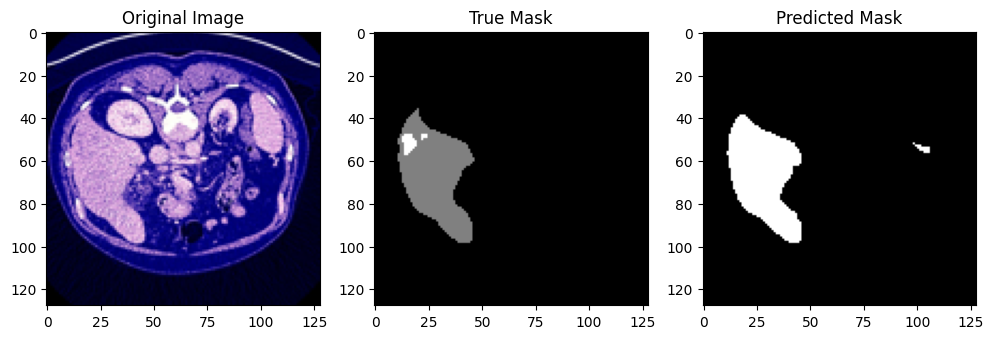

In [64]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have x_test and y_test
# Replace this with the actual index of the image you want to visualize
image_index = 9

# Load the image and true mask
input_image = x_test[image_index]
true_mask = y_test[image_index]

# Obtain the predicted mask from model2
predicted_mask = model3.predict(np.expand_dims(input_image, axis=0))[0]

# Threshold the predicted mask (assuming it's a binary mask)
threshold = 0.5  # Adjust this threshold based on your model's output
predicted_mask_binary = (predicted_mask > threshold).astype(np.uint8)

# Plotting
plt.figure(figsize=(12, 4))

# Plot original image
plt.subplot(1, 3, 1)
plt.imshow(input_image)
plt.title('Original Image')

# Plot true mask
plt.subplot(1, 3, 2)
plt.imshow(true_mask[:, :, 0], cmap='gray')
plt.title('True Mask')

# Plot predicted mask
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask_binary[:, :, 0], cmap='gray')
plt.title('Predicted Mask')

plt.show()


In [ ]:
def mainPage():
    if request.method == 'POST':
        # Handle file upload
        for filename in os.listdir('static/'):
            if filename.startswith('work') or filename.startswith('scan') or filename.startswith('pred') or filename.startswith('slice'):
                os.remove('static/' + filename)

        file = request.files['mri']
        if 'mri' not in request.files or file.filename == '':
            return render_template('index.html', ses=ses, error="File not found!!!")

        filename = secure_filename(file.filename)
        timeStamp = "work" + str(time.time()) + ".jpg"
        filepath = os.path.join(app.config['UPLOAD_FOLDER'], timeStamp)
        file.save(filepath)
            # Process the image to get masks (this part depends on your specific implementation)
        # tumor_mask, organ_mask = process_image(filepath)

        # Calculate the tumor ratio

        # Process the image for prediction using Pillow
        img = Image.open(filepath)
        img = img.resize((128, 128))  # Resize to the input size expected by the model
        img_array = np.expand_dims(np.array(img), axis=0) / 255.0  # Normalize the image
        img_path0 = "scan" + str(time.time()) + ".jpg"

        # Predict using the model
        predicted_mask = learn0.predict(img_array)[0]
        print(f"Predicted mask: {predicted_mask}")  # Debugging: Print the predicted mask
        threshold = 0.5  # Adjust this threshold based on your model's output
        predicted_mask_binary = (predicted_mask > threshold).astype(np.uint8)

        # Save the predicted mask using matplotlib
        pred_path = "pred" + str(time.time()) + ".png"
        plt.imsave(os.path.join(app.config['UPLOAD_FOLDER'], pred_path), predicted_mask_binary[:, :, 0], cmap='gray')

        # Check if the predicted mask is black only
        pred_img = Image.open(os.path.join(app.config['UPLOAD_FOLDER'], pred_path)).convert('L')
        pred_array = np.array(pred_img)
        if np.all(pred_array == 0):
            number = 0
            
        else:
            number = 1

        print(f"Classification: {number}")  # Debugging: Print the classification result
        predicted_results = check(number)
        print(f"Predicted Results: {predicted_results}")  # Debugging: Print the predicted results
        result = 1
        unique, counts = np.unique(predicted_results, return_counts=True)
        pred_matrix = np.array((unique, counts)).T
        print(pred_matrix)
        
        liver_visiblity = 0
        liver_tumor_ratio = 0
        size_result = "-"

        if 1 in unique:
            liver_visiblity = pred_matrix[1][1] / (pred_matrix[0][1] + pred_matrix[1][1]) * 100
            liver_visiblity = float("{:.2f}".format(liver_visiblity))
            print(f"Liver visibility: {liver_visiblity}")  # Debugging: Print the liver visibility
            print(f"Liver tumor ratio: {liver_tumor_ratio}")  # Debugging: Print the liver tumor ratio
            print(f"Size result: {size_result}")  # Debugging: Print the size result
        # tumor_ratio = calculate_tumor_ratio(predicted_mask, img_array)
        if number == 0 :
            tumor_ratio = 0 
            tumor_type = "The patient is healthy"
        else:
            tumor_ratio = calculate_tumor_ratio(predicted_mask, img_array)
            formatted_tumor_ratio = round(tumor_ratio, 2)

            tumor_type = classify_tumor_type(predicted_mask, img_array)



        global ltr, lv, sr
        ltr = liver_tumor_ratio
        lv = liver_visiblity
        sr = size_result
        return render_template("result.html", img1=timeStamp, 

In [ ]:
def segnet_model(input_shape=(128, 128, 3)):
    model2 = tf.keras.Sequential()

    # Encoder
    model2.add(layers.Conv2D(64, (3, 3), padding='same', input_shape=input_shape))
    model2.add(layers.BatchNormalization())
    model2.add(layers.Activation('relu'))
    model2.add(layers.Conv2D(64, (3, 3), padding='same'))
    model2.add(layers.BatchNormalization())
    model2.add(layers.Activation('relu'))
    model2.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model2.add(layers.Conv2D(128, (3, 3), padding='same'))
    model2.add(layers.BatchNormalization())
    model2.add(layers.Activation('relu'))
    model2.add(layers.Conv2D(128, (3, 3), padding='same'))
    model2.add(layers.BatchNormalization())
    model2.add(layers.Activation('relu'))
    model2.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model2.add(layers.Conv2D(256, (3, 3), padding='same'))
    model2.add(layers.BatchNormalization())
    model2.add(layers.Activation('relu'))
    model2.add(layers.Conv2D(256, (3, 3), padding='same'))
    model2.add(layers.BatchNormalization())
    model2.add(layers.Activation('relu'))
    model2.add(layers.Conv2D(256, (3, 3), padding='same'))
    model2.add(layers.BatchNormalization())
    model2.add(layers.Activation('relu'))
    model2.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Decoder
    model2.add(layers.UpSampling2D(size=(2, 2)))
    model2.add(layers.Conv2D(256, (3, 3), padding='same'))
    model2.add(layers.BatchNormalization())
    model2.add(layers.Activation('relu'))
    model2.add(layers.Conv2D(256, (3, 3), padding='same'))
    model2.add(layers.BatchNormalization())
    model2.add(layers.Activation('relu'))
    model2.add(layers.Conv2D(256, (3, 3), padding='same'))
    model2.add(layers.BatchNormalization())
    model2.add(layers.Activation('relu'))

    model2.add(layers.UpSampling2D(size=(2, 2)))
    model2.add(layers.Conv2D(128, (3, 3), padding='same'))
    model2.add(layers.BatchNormalization())
    model2.add(layers.Activation('relu'))
    model2.add(layers.Conv2D(128, (3, 3), padding='same'))
    model2.add(layers.BatchNormalization())
    model2.add(layers.Activation('relu'))

    model2.add(layers.UpSampling2D(size=(2, 2)))
    model2.add(layers.Conv2D(64, (3, 3), padding='same'))
    model2.add(layers.BatchNormalization())
    model2.add(layers.Activation('relu'))
    model2.add(layers.Conv2D(64, (3, 3), padding='same'))
    model2.add(layers.BatchNormalization())
    model2.add(layers.Activation('relu'))

    # Output layer
    model2.add(layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same'))

    return model2

# Create SegNet model
model2 = segnet_model(input_shape=(128, 128, 3))


# Display the model summary
model2.summary()
model2.save('segnet_model2.h5')

In [ ]:
from tensorflow.keras.utils import plot_model
#tf.keras.utils.plot_model(model3, show_shapes=True)
# Assuming you have created the model using the create_fcn_model function
#model3 = create_unet_model()

# Save the model architecture plot to a file
#plot_model(model2, to_file='segnet_model.png', show_shapes=False)

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("segnet_model2.h5", monitor='val_loss', verbose=1, patience = 3,save_best_only=True,
                                                mode='auto')

In [ ]:
from tensorflow.keras.optimizers import Adam
# Compile the model [0.001,0001, 6e-e]
model2.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
              loss= 'binary_crossentropy', metrics=[dice_coefficient])

In [ ]:
# Train the model
history2 = model2.fit(x_train, y_train, epochs=5, batch_size=16,
          validation_data=(x_valid, y_valid), callbacks=[checkpoint])
model2.save('segnet_model2.h5')

In [ ]:
scores2 = model2.evaluate(x_valid, y_valid)
scores2[1]

In [ ]:
prediction2 = model2.predict(x_test)
#print(prediction)
#print(y_test)


In [ ]:
test_scores2 = model2.evaluate(x_test, y_test)
test_scores2[1]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have x_test and y_test
# Replace this with the actual index of the image you want to visualize
image_index = 540

# Load the image and true mask
input_image = x_test[image_index]
true_mask = y_test[image_index]

# Obtain the predicted mask from model2
predicted_mask = model2.predict(np.expand_dims(input_image, axis=0))[0]

# Threshold the predicted mask (assuming it's a binary mask)
threshold = 0.5  # Adjust this threshold based on your model's output
predicted_mask_binary = (predicted_mask > threshold).astype(np.uint8)

# Plotting
plt.figure(figsize=(12, 4))

# Plot original image
plt.subplot(1, 3, 1)
plt.imshow(input_image)
plt.title('Original Image')

# Plot true mask
plt.subplot(1, 3, 2)
plt.imshow(true_mask[:, :, 0], cmap='gray')
plt.title('True Mask')

# Plot predicted mask
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask_binary[:, :, 0], cmap='gray')
plt.title('Predicted Mask')

plt.show()

In [ ]:
# Step 2: Apply weights to the predictions
unet_weight = 0.98
fcn_weight = 0.71
segnet_weight = 0.99
sum_weights = unet_weight + fcn_weight + segnet_weight

w_unet = unet_weight / sum_weights
w_fcn = fcn_weight / sum_weights
w_segnet = segnet_weight / sum_weights

# Step 3: Take element-wise maximum prediction
weighted_prediction = np.maximum(w_unet * prediction1, w_fcn * prediction, w_segnet * prediction2)


In [ ]:
# Step 4: Take argmax along the last axis
final_prediction = np.argmax(weighted_prediction, axis=-1)

# Step 5: Calculate the testing score using the combined predictions
test_scores1 = model2.evaluate(x_test, y_test)
test_scores2 = model3.evaluate(x_test, y_test)
weighted_test_score = w_unet * test_scores[1] + w_fcn * model.evaluate(x_test, y_test)[1] + w_segnet*test_scores1[1]

print(f'Testing score with weighted predictions: {weighted_test_score}')

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have an image, true mask, and final_prediction
image_index = 38  # Adjust this based on the image you want to visualize

# Load the image, true mask, and predicted mask
input_image = x_test[image_index]
true_mask = y_test[image_index]
predicted_mask = final_prediction[image_index]

# Plotting
plt.figure(figsize=(12, 4))

# Plot original image
plt.subplot(1, 3, 1)
plt.imshow(input_image)
plt.title('Original Image')

# Plot true mask
plt.subplot(1, 3, 2)
plt.imshow(true_mask[:, :, 0], cmap='gray')
plt.title('True Mask')

# Plot predicted mask
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask, cmap='gray')
plt.title('Predicted Mask')

plt.show()